In [1]:
import pandas as pd
import numpy as np
from loaders import wind_data
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.pyplot as plt
import pickle


TEST_SIZE = 50
TRAIN_SIZE = 631
ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']

wind_GEF = wind_data(path_name='data/wind_data_all_zone.csv', test_size=TEST_SIZE, random_state=0)

wind_df = pd.read_csv('data/wind_data_all_zone.csv')

wind_df['OLD_TIMESTAMP'] =  pd.to_datetime(wind_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
wind_df['TIMESTAMP'] =  pd.DatetimeIndex(wind_df['OLD_TIMESTAMP']) + pd.offsets.Hour(-1)
wind_df['new_date'] = [d.date() for d in wind_df['TIMESTAMP']]
# scaler = MinMaxScaler()
# scaler.fit([wind_df['TARGETVAR']])
# wind_df['TARGETVAR'] = scaler.transform([wind_df['TARGETVAR']])[0]


#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days


In [2]:
wind_df['ws10'] = np.sqrt(wind_df['U10'].values ** 2 + wind_df['V10'].values ** 2)
wind_df['ws100'] = np.sqrt(wind_df['U100'].values ** 2 + wind_df['V100'].values ** 2)
wind_df['we10'] = 0.5 * 1 * wind_df['ws10'].values ** 3
wind_df['we100'] = 0.5 * 1 * wind_df['ws100'].values ** 3
wind_df['wd10'] = np.arctan2(wind_df['U10'].values, wind_df['V10'].values) * 180 / np.pi
wind_df['wd100'] = np.arctan2(wind_df['U100'].values, wind_df['V100'].values) * 180 / np.pi
wind_df

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,ZONE_1,ZONE_2,ZONE_3,ZONE_4,...,ZONE_9,ZONE_10,OLD_TIMESTAMP,new_date,ws10,ws100,we10,we100,wd10,wd100
0,2012-01-01 00:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,0,0,0,...,0,0,2012-01-01 01:00:00,2012-01-01,3.421530,4.652334,20.027704,50.348042,141.614439,141.999735
1,2012-01-01 01:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,1,0,0,0,...,0,0,2012-01-01 02:00:00,2012-01-01,3.096451,4.154892,14.844401,35.863219,125.473680,126.385781
2,2012-01-01 02:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,1,0,0,0,...,0,0,2012-01-01 03:00:00,2012-01-01,2.795932,3.712577,10.928235,25.585651,107.108562,109.088098
3,2012-01-01 03:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,1,0,0,0,...,0,0,2012-01-01 04:00:00,2012-01-01,2.461699,3.234831,7.458899,16.924853,93.345160,96.310236
4,2012-01-01 04:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,1,0,0,0,...,0,0,2012-01-01 05:00:00,2012-01-01,2.279435,2.976332,5.921775,13.182994,80.159324,83.581938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175435,2013-12-31 19:00:00,0.792143,1.032363,-6.281558,2.041033,-11.220655,0,0,0,0,...,0,1,2013-12-31 20:00:00,2013-12-31,6.365826,11.404776,128.983535,741.703478,170.666975,169.690637
175436,2013-12-31 20:00:00,0.792143,1.702361,-6.202448,2.846245,-10.486079,0,0,0,0,...,0,1,2013-12-31 21:00:00,2013-12-31,6.431827,10.865494,133.037165,641.384473,164.652195,164.814040
175437,2013-12-31 21:00:00,0.792143,5.086629,-1.261378,7.382256,-3.097656,0,0,0,0,...,0,1,2013-12-31 22:00:00,2013-12-31,5.240694,8.005821,71.967502,256.559243,103.927218,112.763328
175438,2013-12-31 22:00:00,0.792143,4.183751,-1.580172,5.789054,-2.116548,0,0,0,0,...,0,1,2013-12-31 23:00:00,2013-12-31,4.472216,6.163840,44.723763,117.091161,110.691183,110.083020


In [3]:
import datetime

test_dates = []
for d in wind_GEF[5].index:
    test_dates.append(d.date())

train_dates = []
for d in wind_GEF[1].index:
    train_dates.append(d.date())
    
val_dates = []
for d in wind_GEF[3].index:
    val_dates.append(d.date())

test_dates = pd.Series(test_dates)
train_dates = pd.Series(train_dates)
val_dates = pd.Series(val_dates)
train = wind_df[~wind_df['new_date'].isin(test_dates.unique())].copy()
test = wind_df[wind_df['new_date'].isin(test_dates.unique())].copy()
val = wind_df[wind_df['new_date'].isin(test_dates.unique())].copy()
x_train = train[['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100',	'we10',	'we100', 'wd10', 'wd100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
x_test = test[['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100',	'we10',	'we100', 'wd10', 'wd100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
x_val = val[['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100',	'we10',	'we100', 'wd10', 'wd100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
y_train = train['TARGETVAR']
y_test = test['TARGETVAR']
y_val = val['TARGETVAR']

In [11]:
# sorted_train_predictions = pickle.load(open("pickles/wind_sorted_train_predictions.pickle",'rb'))
# sorted_predictions = pickle.load(open("pickles/wind_sorted_predictions.pickle",'rb'))


In [12]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_pinball_loss, mean_squared_error

# num_quantiles = 100
# quantiles = np.arange(0, 1, 1/num_quantiles)[1:]

# common_params = dict(
#     learning_rate=0.05,
#     n_estimators=600,
#     max_depth=7,
#     min_samples_leaf=9,
#     min_samples_split=9,
# )

# predictions = []
# train_predictions = []
# for alpha in quantiles:
#     gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
#     model = gbr.fit(x_train, y_train)
#     y_pred = gbr.predict(x_test)

#     x_pred = gbr.predict(x_train)
#     predictions.append(y_pred)
#     train_predictions.append(x_pred)
#     print(alpha)
# predictions = np.array(predictions)
# train_predictions = np.array(train_predictions)

# sorted_predictions = np.sort(predictions, axis=0)
# sorted_train_predictions = np.sort(train_predictions, axis=0)

# results = []
# for i, q in enumerate(quantiles):
#     results.append(mean_pinball_loss(y_test, sorted_predictions[i], alpha=q))

# plt.plot(quantiles, results)
# plt.ylabel('mean pinball loss')
# plt.xlabel('quantiles')
# plt.show()

In [28]:
sorted_predictions = np.sort(predictions, axis=0)
sorted_train_predictions = np.sort(train_predictions, axis=0)

Quantile sqore: 4.227631074138713


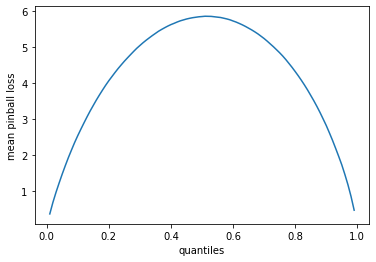

In [29]:
import metrics

plf = metrics.plf_per_quantile(sorted_predictions, y_test)
print("Quantile sqore:", plf.mean())
plt.plot(quantiles, plf)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

In [30]:
y_copy = pd.DataFrame(y_test.copy())
y_copy['pos'] = np.arange(y_test.shape[0])
y_copy['old_pos'] = y_copy.index
y_copy

,TARGETVAR,pos,old_pos
24,0.439244,0,24
25,0.205808,1,25
26,0.190020,2,26
27,0.803496,3,27
28,0.755004,4,28
...,...,...,...
175387,0.285135,11995,175387
175388,0.210316,11996,175388
175389,0.135190,11997,175389
175390,0.030001,11998,175390


C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


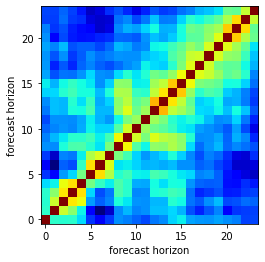

In [31]:
import copula
idx = np.arange(TEST_SIZE)
np.random.shuffle(idx)
ZONE = 'ZONE_6'
cov_matrix = np.identity(24)

for i in idx:
    pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
    actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']
    cov_matrix = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                      actual_data=actual_data, forget_factor=0.98, cov_matrix=cov_matrix)
    
plt.imshow(cov_matrix, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')

plt.show()

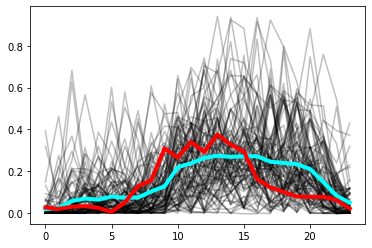

In [32]:
N_SCENARIOS = 50

ZONE = 'ZONE_6'
pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']

generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=100, rnd_seed=[0], sort=True)
plt.plot(generated_scenarios.values, color='k', alpha=0.25)
plt.plot(generated_scenarios.values.mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), actual_data, color='red', linewidth=4)
plt.show()

In [33]:
ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']
y_to_pass = []
scenarios_pred = []
for zone in ZONES:

    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)


In [34]:
y_to_pass = np.array(y_to_pass)

scenarios_pred = np.array(scenarios_pred)
scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)
scenarios_pred.shape

(12000, 50)

In [35]:
import metrics

energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)
np.array(energy_scoring).mean() * 100

54.325853022094165

In [36]:
import copula
y_train_copy = pd.DataFrame(y_train.copy())
y_train_copy['pos'] = np.arange(y_train.shape[0])
y_train_copy['old_pos'] = y_train_copy.index

N_SCENARIOS = 100
idx = np.arange(TRAIN_SIZE)
np.random.shuffle(idx)

cov_matrixes = {}
for zone in ZONES:
    cov_matrixes[zone] = np.identity(24)
    for i in idx:
        pred = pd.DataFrame(sorted_train_predictions[:,y_train_copy[y_train_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == train_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_train_copy[y_train_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == train_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        cov_matrixes[zone] = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                          actual_data=actual_data, forget_factor=0.99, cov_matrix=cov_matrixes[zone])
        
y_to_pass = []
scenarios_pred = []
for zone in ZONES:

    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrixes[zone], n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)

y_to_pass = np.array(y_to_pass)

scenarios_pred = np.array(scenarios_pred)
scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)
print(scenarios_pred.shape)

pickleFile = open("pickles/wind_scenarios.pickle", 'wb')

pickle.dump(scenarios_pred, pickleFile)
pickleFile.close()


energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)
print("Average energy score:", np.array(energy_scoring).mean() * 100)

C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(12000, 100)
Average energy score: 53.26482595859384


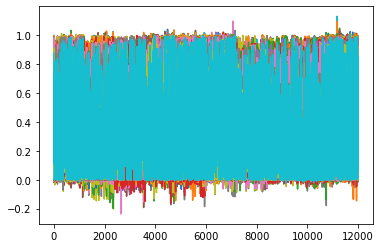

In [37]:
#np.sum(scenarios_pred > 1)
plt.plot(scenarios_pred)
plt.show()

In [38]:
dict_results = {}
mean_scores = []
for zone in ZONES:
    y_to_pass = []
    scenarios_pred = []
    weather_features = []
    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        weather_features_day = wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)][['U10', 'V10', 'U100', 'V100']]
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrixes[zone], n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        weather_features.append(weather_features_day)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)
        
    y_to_pass = np.array(y_to_pass)

    scenarios_pred = np.array(scenarios_pred)
    scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)
    energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)
    mean_energy_score = np.array(energy_scoring).mean() * 100
    mean_scores.append(mean_energy_score)
    dict_results[zone] = {'predictions':scenarios_pred, 'Ys': y_to_pass, 'energy_scores': energy_scoring, 'mean_score':mean_energy_score, 'weather_features': weather_features}
    print("Average energy score in ", zone, mean_energy_score)

Average energy score in  ZONE_1 56.02793541835155
Average energy score in  ZONE_2 42.502254198938815
Average energy score in  ZONE_3 50.6030655760741
Average energy score in  ZONE_4 54.342490470497005
Average energy score in  ZONE_5 56.62438010950856
Average energy score in  ZONE_6 59.8781326207502
Average energy score in  ZONE_7 39.953266564082114
Average energy score in  ZONE_8 51.05046468010694
Average energy score in  ZONE_9 52.289022375384455
Average energy score in  ZONE_10 69.37724757224464


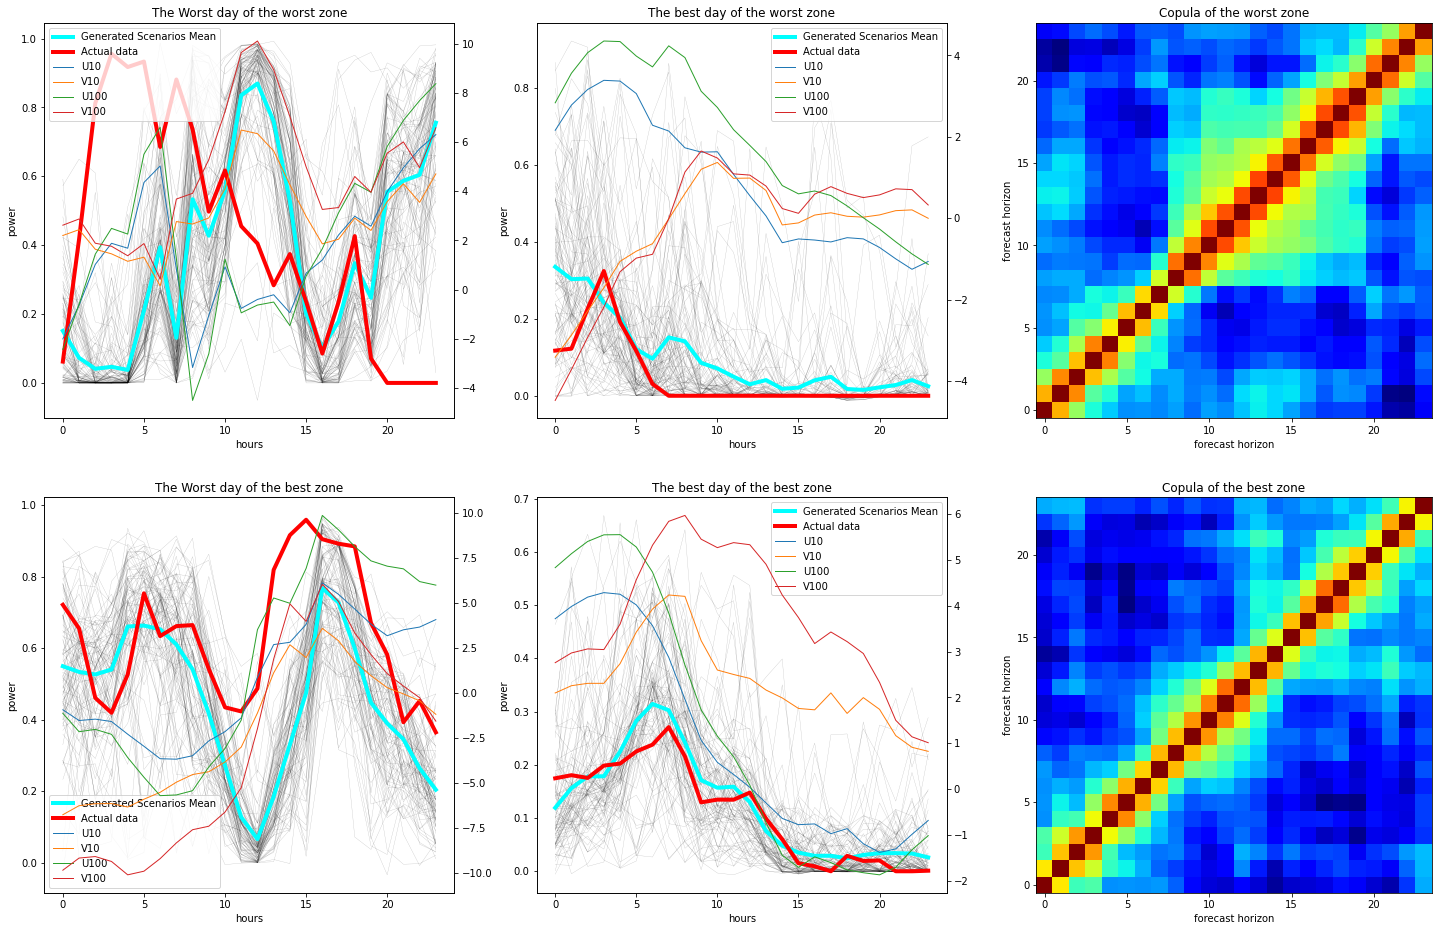

In [39]:
mean_scores = np.array(mean_scores)
Worst_zone = 'ZONE_' + str(np.argmax(mean_scores) + 1)
Best_zone = 'ZONE_' + str(np.argmin(mean_scores) + 1)

columns = 3
rows = 2

fig, ax = plt.subplots(rows, columns, figsize=(25, 16))

worst_day = np.argmax(dict_results[Worst_zone]['energy_scores'])
best_day = np.argmin(dict_results[Worst_zone]['energy_scores'])

ax[0, 0].set_title("The Worst day of the worst zone")
ax[0, 0].plot(dict_results[Worst_zone]['predictions'][worst_day*24:worst_day*24+24], color='k', alpha=0.25, linewidth = 0.3)
lns = ax[0, 0].plot(dict_results[Worst_zone]['predictions'][worst_day*24:worst_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
lns += ax[0, 0].plot(np.arange(24), dict_results[Worst_zone]['Ys'][worst_day], color='red', linewidth=4, label='Actual data')
ax2 = ax[0, 0].twinx()
for columnName, columnData in dict_results[Worst_zone]['weather_features'][worst_day].iteritems():
    lns += ax2.plot(np.arange(24), columnData, label=columnName, linewidth = 1)
labs = [l.get_label() for l in lns]
ax[0, 0].legend(lns, labs, loc=0)
ax[0, 0].set_ylabel('power')
ax[0, 0].set_xlabel('hours')

ax[0, 1].set_title("The best day of the worst zone")
ax[0, 1].plot(dict_results[Worst_zone]['predictions'][best_day*24:best_day*24+24], color='k', alpha=0.25, linewidth = 0.3)
lns = ax[0, 1].plot(dict_results[Worst_zone]['predictions'][best_day*24:best_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
lns += ax[0, 1].plot(np.arange(24), dict_results[Worst_zone]['Ys'][best_day], color='red', linewidth=4, label='Actual data')
ax2 = ax[0, 1].twinx()
for columnName, columnData in dict_results[Worst_zone]['weather_features'][best_day].iteritems():
    lns += ax2.plot(np.arange(24), columnData, label=columnName, linewidth = 1)
labs = [l.get_label() for l in lns]
ax[0, 1].legend(lns, labs, loc=0)
ax[0, 1].set_ylabel('power')
ax[0, 1].set_xlabel('hours')

ax[0, 2].set_title("Copula of the worst zone")
pos = ax[0, 2].imshow(cov_matrixes[Worst_zone], cmap='jet', origin='lower')
ax[0, 2].set_xlabel('forecast horizon')
ax[0, 2].set_ylabel('forecast horizon')

worst_day = np.argmax(dict_results[Best_zone]['energy_scores'])
best_day = np.argmin(dict_results[Best_zone]['energy_scores'])

ax[1, 0].set_title("The Worst day of the best zone")
ax[1, 0].plot(dict_results[Best_zone]['predictions'][worst_day*24:worst_day*24+24], color='k', alpha=0.25, linewidth = 0.3)
lns = ax[1, 0].plot(dict_results[Best_zone]['predictions'][worst_day*24:worst_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
lns += ax[1, 0].plot(np.arange(24), dict_results[Best_zone]['Ys'][worst_day], color='red', linewidth=4, label = 'Actual data')
ax2 = ax[1, 0].twinx()
for columnName, columnData in dict_results[Best_zone]['weather_features'][worst_day].iteritems():
    lns += ax2.plot(np.arange(24), columnData, label=columnName, linewidth = 1)
labs = [l.get_label() for l in lns]
ax[1, 0].legend(lns, labs, loc=0)
ax[1, 0].set_ylabel('power')
ax[1, 0].set_xlabel('hours')


ax[1, 1].set_title("The best day of the best zone")
ax[1, 1].plot(dict_results[Best_zone]['predictions'][best_day*24:best_day*24+24], color='k', alpha=0.25, linewidth = 0.3)
lns = ax[1, 1].plot(dict_results[Best_zone]['predictions'][best_day*24:best_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
lns += ax[1, 1].plot(np.arange(24), dict_results[Best_zone]['Ys'][best_day], color='red', linewidth=4, label = 'Actual data')
ax2 = ax[1, 1].twinx()
for columnName, columnData in dict_results[Best_zone]['weather_features'][best_day].iteritems():
    lns += ax2.plot(np.arange(24), columnData, label=columnName, linewidth = 1)
labs = [l.get_label() for l in lns]
ax[1, 1].legend(lns, labs, loc=0)
ax[1, 1].set_ylabel('power')
ax[1, 1].set_xlabel('hours')

ax[1, 2].set_title("Copula of the best zone")
pos = ax[1, 2].imshow(cov_matrixes[Best_zone], cmap='jet', origin='lower')
ax[1, 2].set_xlabel('forecast horizon')
ax[1, 2].set_ylabel('forecast horizon')

plt.show()

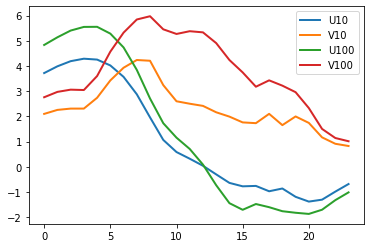

In [40]:
for columnName, columnData in dict_results[Best_zone]['weather_features'][best_day].iteritems():
    plt.plot(np.arange(24), columnData, label=columnName, linewidth = 2)
plt.legend()
plt.show()

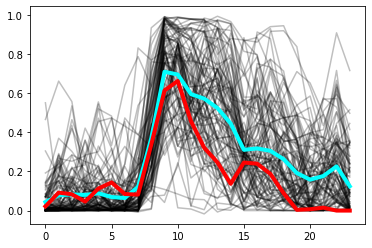

In [41]:
plt.plot(generated_scenarios.values, color='k', alpha=0.25)
plt.plot(generated_scenarios.values.mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), actual_data, color='red', linewidth=4)
plt.show()

In [42]:
generated_scenarios.values.shape

(24, 100)

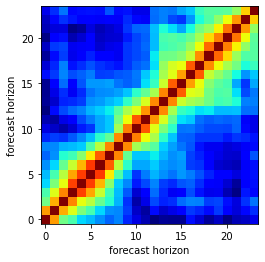

In [43]:
plt.imshow(cov_matrixes['ZONE_1'], cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')

plt.show()

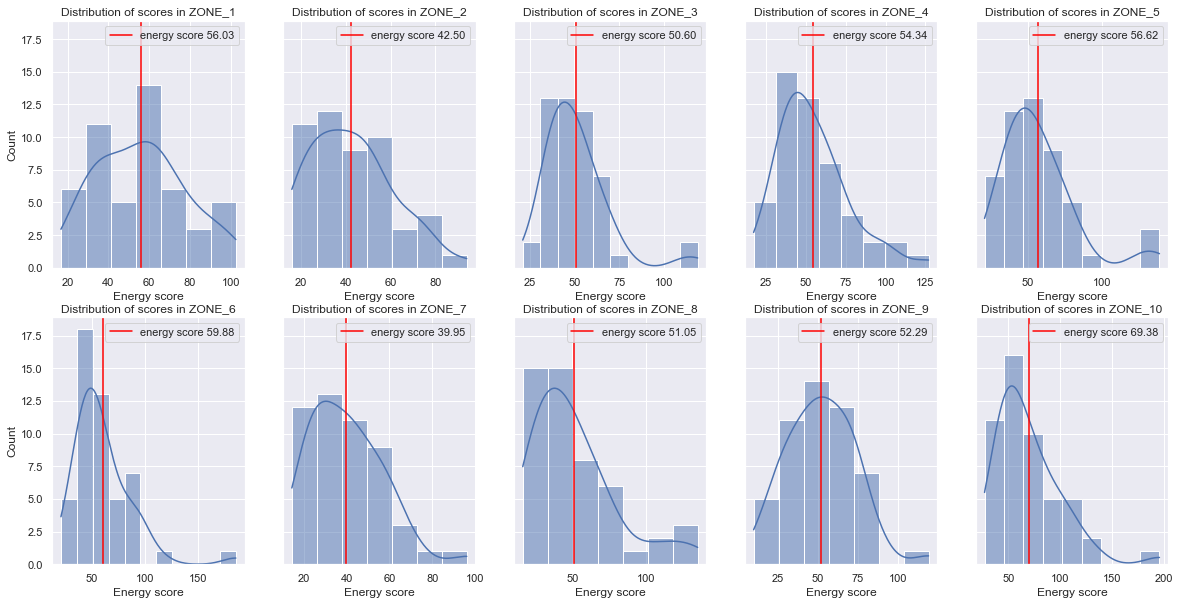

In [44]:
import seaborn as sns, numpy as np

columns, rows = 5, 2
sns.set()
fig, axes = plt.subplots(rows, columns, figsize=(20, 10), sharey=True)
for i, zone in enumerate(ZONES):
    row = 0
    if i >= columns: row = 1
    scores = np.array(dict_results[zone]['energy_scores']) * 100
    sns.histplot(scores, ax=axes[row, i%columns], kde = True)
    axes[row, i%columns].set_xlabel("Energy score")
    axes[row, i%columns].axvline(x=scores.mean(), color='red', label="energy score " + f'{scores.mean():.2f}')
    axes[row, i%columns].set_title("Distribution of scores in " + zone)
    axes[row, i%columns].legend()
plt.show()

In [45]:
dict_results[zone]['energy_scores']

[0.6089748880536011,
 1.0448765036706698,
 0.44903905669919597,
 0.5967539561598614,
 0.7461774064159208,
 1.1117129601720306,
 1.0145594001860498,
 1.9574349561925466,
 0.8532688407187307,
 0.7576487819152258,
 1.0547052250056654,
 0.5945977586627231,
 0.8913685054096768,
 1.0653285941850892,
 0.6763001985318612,
 0.4290274054648211,
 0.3233022565906365,
 0.5641401696373876,
 0.7684036858239414,
 0.5293961399397866,
 0.7833325732380549,
 0.7138123185115921,
 0.7476943025071792,
 0.5051589409411366,
 0.4846116234056852,
 0.30858747732197855,
 0.4224478956659271,
 0.41912130202989184,
 0.6962959514814939,
 0.462824096546226,
 0.5823431273032244,
 0.5057107505952538,
 1.3143220691442608,
 0.442686318042628,
 0.5351523730240457,
 0.6505475271946428,
 0.5290586593312835,
 0.26889027213466854,
 0.8571926409840798,
 0.3998710555037963,
 0.6078032238342468,
 1.287300619329986,
 0.432644103197772,
 1.0711674751747662,
 0.825436420985508,
 0.9077918180719745,
 0.4951588977495731,
 0.50416911251

In [46]:
import pickle

pickleFile = open("pickles/scenarios_wind_random_100_TEST.pickle", 'rb')
wind_random = pickle.load(pickleFile)
pickleFile.close()
y_to_pass = []
for zone in ZONES:

    for i in range(TEST_SIZE):
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        y_to_pass.append(actual_data)
y_to_pass = np.array(y_to_pass)

wind_random = wind_random.reshape(-1, N_SCENARIOS)

energy_scoring = metrics.energy_score(wind_random, y_to_pass)
print("Average energy score:", np.array(energy_scoring).mean() * 100)

Average energy score: 53.367055746253214


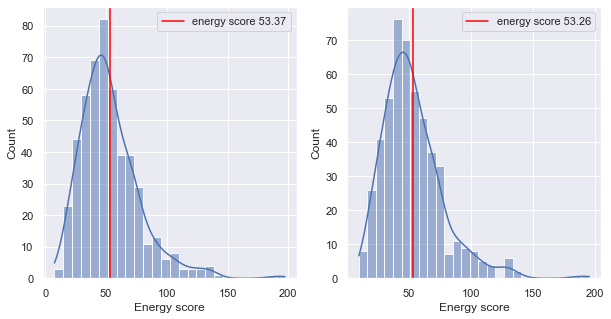

In [47]:
all_scores = []
for zone in ZONES:
    all_scores.append(dict_results[zone]['energy_scores'])

all_scores = np.array(all_scores)
all_scores= all_scores.reshape(-1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
energy_scoring = np.array(energy_scoring) * 100
sns.histplot(energy_scoring, ax = ax[0], kde = True)
ax[0].set_xlabel("Energy score")
ax[0].axvline(x=energy_scoring.mean(), color='red', label="energy score " + f'{energy_scoring.mean():.2f}')
ax[0].legend()
all_scores = np.array(all_scores) * 100
sns.histplot(all_scores, ax = ax[1], kde = True)
ax[1].set_xlabel("Energy score")
ax[1].axvline(x=all_scores.mean(), color='red', label="energy score " + f'{all_scores.mean():.2f}')
ax[1].legend()
plt.show()

In [48]:
pickleFile1 = open("pickles/wind_sorted_predictions.pickle", 'wb')
pickleFile2 = open("pickles/wind_sorted_train_predictions.pickle", 'wb')

pickle.dump(sorted_predictions, pickleFile1)
pickle.dump(sorted_train_predictions, pickleFile2)
pickleFile1.close()
pickleFile2.close()

In [ ]:
#0) correct the date issue
#1) apply on solar and power
#2) do some stuff with visualization - best and worth scores of best and worth zones
#3) feature engineering (include time of the day)


#1) Weather features subplot
#2) Add weather features visualizations

#1) Write stuff down for discussion session!!!!!!!!!!!!!!!!
#2) Use RAND baseline to plot the distribution


#1) Statistical measurement of fit (p-value for fitness)
#2) Add features from the original competition
#3) Read the papers, focus on the data.

In [ ]:
dict_results[zone]['energy_scores']